# PyHC TECH DEMO: aMTM Periodicity Detector--Python Version v0.0.9
## 10-7-2024
### Hector Salinas
#### Tech DEMO on using this python package's functions to produce an aMTM power spectral density (PSD), model the background noise PSD, and identify discrete periodicities in data series
* Link to the python package `amtm-signaldetect`: https://pypi.org/project/amtm-signaldetect/
* Link to the GitHub: https://github.com/hsalinasGIT/amtm_signaldetect'
* (7-17-2024) Current iteration of the python package has functions which returns the data arrays of the spectral data products. Explicit plotting modules to be implemented in the future
* This algorithm of Periodic Signal Detection is a Python version to the already designed/published IDL procedure 
    * (6-29-2023)Simone's Paper describing his IDL code (Di Matteo 2021, JGR): 
        * https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020JA028748
    * (7-14-2023)The imported multitaper method (MTM) python package ws designed by German Prieto
        * https://github.com/gaprieto/multitaper
        * Their website: https://gaprieto.com/software/


In [1]:
%matplotlib inline 
#^--plot figures in command line

#The Periodic Signal Detection Python Package--v
from amtm_signaldetect import*  #importing all the aMTM Signal Detection Packages


#Additional packages for general math and plotting--v
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec #nice alternatie way of doing subplots
import numpy as np
import random

Nyquist frequency =  0.5 , dt =  1 , T =  511 , N =  512
Creating Prieto MTSPEC class for Data(NW = 2, Ktpr = 3)
Nyquist frequency =  0.5 , dt =  1 , T =  511 , N =  512
Creating Prieto MTSPEC class for Data(NW = 2, Ktpr = 3)


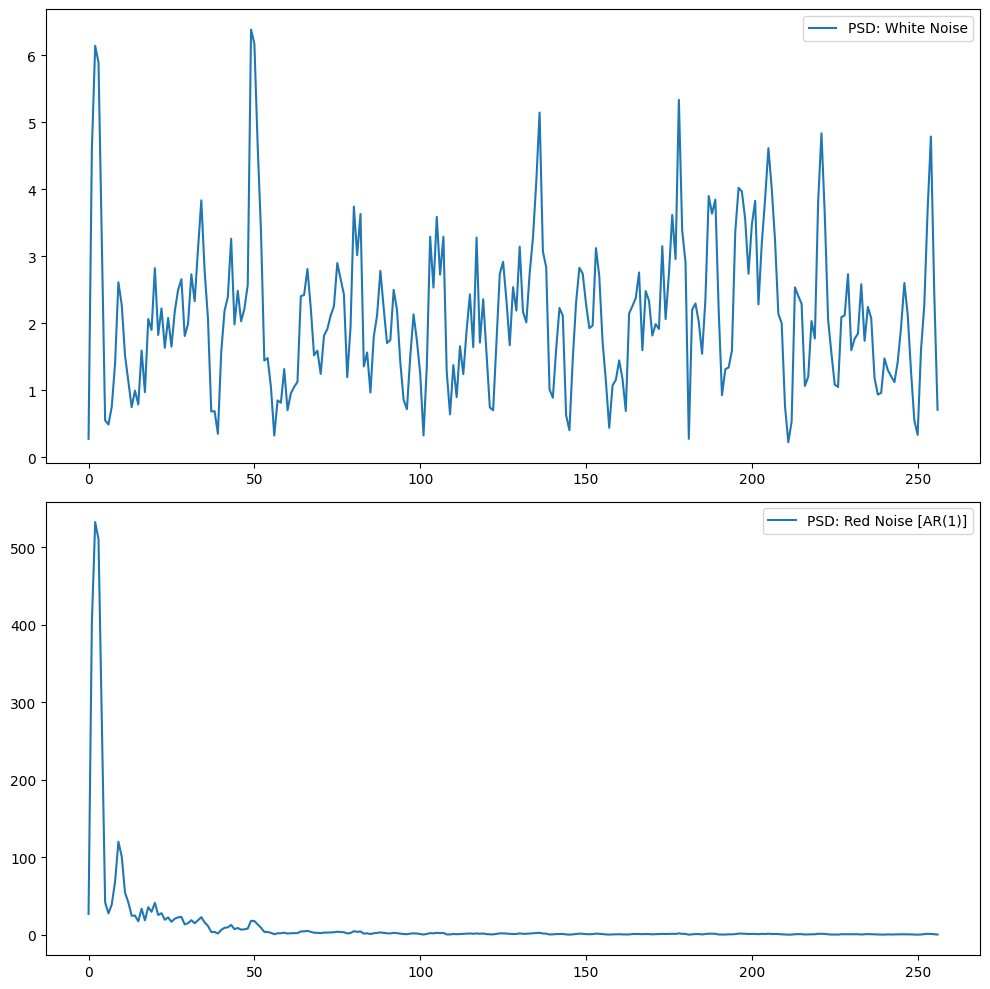

In [2]:
def get_ar1_rednoise(fLength, afW):
    """Generate Red Noise using AR1: x[t+1] = rho*x[t] + w[n], where w[n] = white noise"""
    #Initialize red noise array and define afRed[0]
    afRed = np.empty(fLength) 
    afRed[0] = afW[0]
    #Generate AR(1) red noise array
    rho = 0.9
    for i in range(fLength-1):
        afRed[i+1] = rho*afRed[i] + afW[i]
    return(afRed);

def test_red_noise():
    """Testing AR(1) red noise comparison with white noise"""
    afTime = np.arange(0,512,1) #time array from 0-511seconds, dt = 1
    np.random.seed(2) #define seed so we get consistent random values
    mu, sigma = 0, 1 # standard normal distribution (Gaussian with mu = 0 and sigma = 1)
    afWhite = np.random.normal(mu, sigma, len(afTime)) #making white noise based on normal (Gaussian) distribution
    afRed = get_ar1_rednoise(len(afTime), afWhite) #return AR(1) red noise
    #--Define aMTM PSDs of red and white noise time series
    achSpect = ''
    [afFk_w, afSk_w, afAlphak_w, afFtest_w] = get_amtm_specs(afWhite, afTime, achSpect, 2) #NW = 3, Ktpr = 5
    [afFk_r, afSk_r, afAlphak_r, afFtest_r] = get_amtm_specs(afRed, afTime, achSpect, 2) #NW = 3, Ktpr = 5
    #--Plot Data
    fig, ax = plt.subplots(2, figsize = (10,10))
    ax[0].plot(afSk_w, label = 'PSD: White Noise')
    ax[1].plot(afSk_r, label = 'PSD: Red Noise [AR(1)]')
    ax[0].legend(loc = 'best')
    ax[1].legend(loc = 'best')
    plt.tight_layout()
    return;

test_red_noise()

## 1) Simple Example of Returning aMTM Spectral Data Products
* `get_amtm_specs()`**uses Prieto's MTM package and returns an aMTM power spectral density (PSD) ($S_k$), the corresponding Fourier frequencies ($f_k$), the half-degrees of freedom ($α_k$), and the Harmonic F-test ($F_k$) over the positive frequency range [0, $f_{ny}$].** 
---
* The below test cell produces/plots the aMTM PSD of a time series of a pure sine wave embedded in white noise. We call simply call our function as:
    * `[afFreqk, afSk, afAlphak, afFtestk] = get_amtm_specs(afX, afT, achFull, nw_in)`
        * `achFull = 'full'` returns spectral dataproducts over the full frequency range, and all other str options defaults to the positive frequency spectrum

In [3]:
help(get_amtm_specs)

Help on function get_amtm_specs in module amtm_signaldetect.aMTMSignalDetect:

get_amtm_specs(xdata, tdata, achFull, NW, Ktpr=None)
    Using Prieto's MTM python package: Compute/return the aMTM PSD, corresponding frequencies, 
    half-degrees of freedom, and F-test arrays over the positive frequency range [0, fny]
    
    :Params:
        xdata: data series to be Fourier transformed (ie. X(t), Y(t), etc)
        tdata: corresponding "time" series of above data series
        achFull: (str) option to return spectral products over full or positive frequency spectrum
        NW: (>1, an integer) frequency resolution bandwidth
        Ktpr: (optional, int) number of tapers to use 
    :Returns:
        afFreq_pf: corresponding Fourier frequencies defined over positive frequency (pf) range
        afSk_pf: aMTM PSD estimate defined of positive frequency range
        afAlphak_pf: half-degrees of freedom defined over positive frequency range
        afFtest_pf: Harmonic F-test defined ove

Nyquist frequency =  50.0 , dt =  0.01 , T =  4.99 , N =  500
Creating Prieto MTSPEC class for Data(NW = 3, Ktpr = 5)


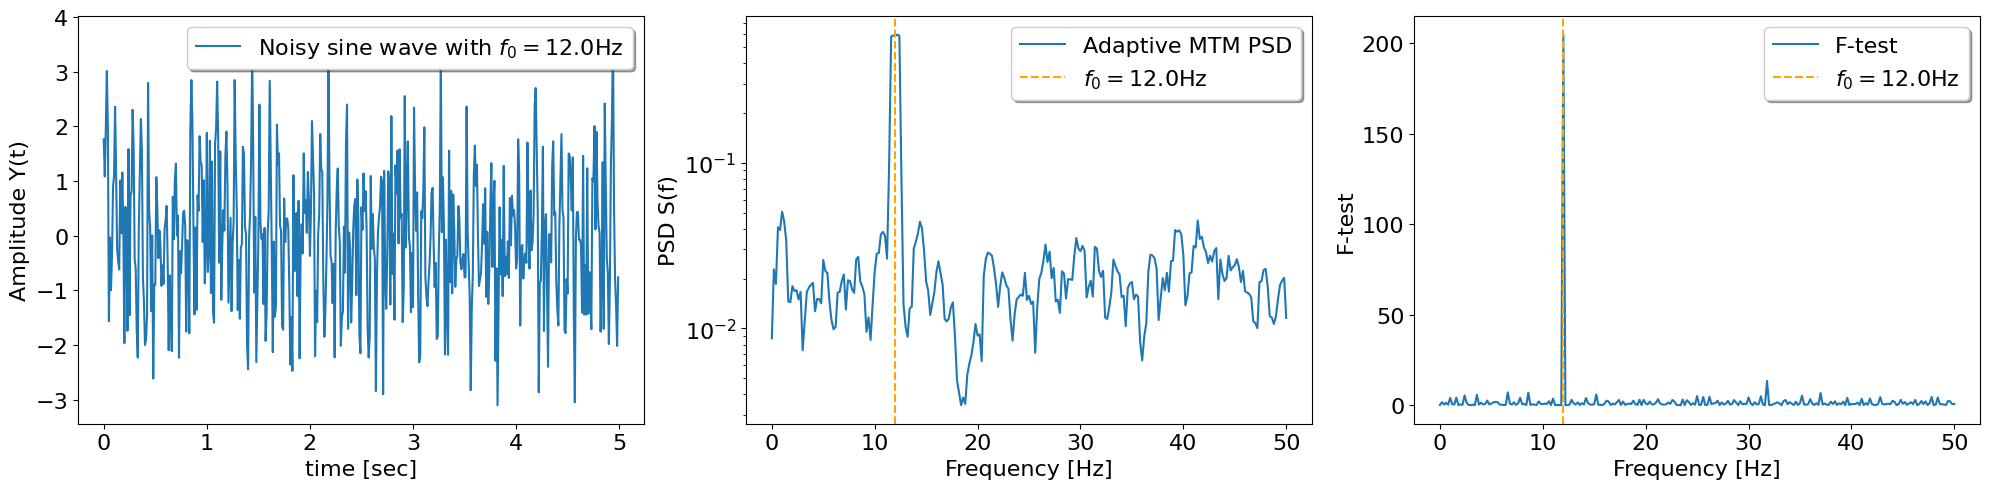

In [4]:
fSine = lambda A,f,t: A*np.sin(2*np.pi*f*t) #Defining anonymous functions (Python's version of explicit math functions)


def test_get_amtm():
    """Test get_amtm_specs"""
    #----------Generating Time Series---------------v
     #-OG Data params-
    ds = 100 #sampling rate, equivalent to dt = 0.002s
    dt = 1/ds
    afT = np.arange(0, 5, dt) #5 second interval with 1000 dtps (N = T*ds or T = N*dt)
    #N = len(afT)
    #f_ray = 1/(N*dt)
    #f_nyq = 1/(2*dt)
    #print('Rayleigh frequency is', f_ray, 'and N = ', N)
    #-Defining various time series
    freq1 = 12#8.0
    OG_sine = fSine(1,freq1,afT) #pure sine wave with f = freq1 Hz
    np.random.seed(0) #define seed so we get consistent random values
    mu, sigma = 0, 1 # standard normal distribution (Gaussian with mu = 0 and sigma = 1)
    afWhite = np.random.normal(mu, sigma, len(afT)) #making white noise based on normal (Gaussian) distribution
    #---Define time series with [insert] noise----
    achNoise = ''
    if achNoise == 'red': #make time series embedded in red noise (AR(1))
        afRed = get_ar1_rednoise(len(afT), afWhite) #return AR(1) red noise
        afX = OG_sine + afRed #define sine wave embedded in red noise
    else: #make time series embedded in white noise
        afX = OG_sine + afWhite #define sine wave embedded in white noise
    
    
    #-----------------------------------------------
    #---------Producing aMTM Spectral Dataproducts from data series---------v
    nw_in = 3 #Ktpr = 5
    achSpect = ''
    [afFreq_mtm, afSk_mtm, afAlpha_mtm, Ftest_mtm] = get_amtm_specs(afX, afT, achSpect,nw_in) #extract Pietro aMTM PSD and dpss
    #-----------------------------------------------------------------------
    
    
    #--Plotting aMTM Spectral Dataproducts--------------------------v
    #-Using GridSpec to plot the various time series and corresponding FFTs
    fig = plt.figure(figsize = (20,5))
    gs = GridSpec(1, 3, figure=fig) # (Row x Col) plot
    ax1 = fig.add_subplot(gs[0, 0]) 
    ax2 = fig.add_subplot(gs[0, 1]) 
    ax3 = fig.add_subplot(gs[0, 2]) 
    fsize = 16 #fontsize of axis labels/ticks
    legsize = 18 #legend fontsize
    tsize = 12 #titlesize    
        #-Plotting Time Series
    ax1.plot(afT, afX, label = r'Noisy sine wave with $f_0 = %0.1f$Hz'%(freq1))
    ax1.legend(loc = 'upper right', shadow = True, prop={'size': legsize-2})
    ax1.set_ylabel('Amplitude Y(t)', fontsize = fsize)
    ax1.set_xlabel('time [sec]', fontsize = fsize)
        #-Plotting PSD
    ax2.semilogy(afFreq_mtm, afSk_mtm, label = 'Adaptive MTM PSD')
    ax2.axvline(freq1, color = 'orange', ls = '--', label = r'$f_0 = %0.1f$Hz'%(freq1))
    ax2.set_ylabel('PSD S(f)', fontsize = fsize)
    ax2.set_xlabel('Frequency [Hz]', fontsize = fsize)
    #ax2.set_xlim(0, 30)
        #-Plotting Ftest
    ax3.plot(afFreq_mtm, Ftest_mtm, label = 'F-test')
    ax3.axvline(freq1, color = 'orange', ls = '--', label = r'$f_0 = %0.1f$Hz'%(freq1))
    ax3.set_xlabel(r'Frequency [Hz]', fontsize = fsize)
    ax3.set_ylabel('F-test', fontsize = fsize)
    #ax3.set_xlim(0, 30)
    ax1.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax2.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax3.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
        #-Setting tick axes labelsize
    ax1.tick_params(axis='both', labelsize=fsize)
    ax2.tick_params(axis='both', labelsize=fsize) 
    ax3.tick_params(axis='both', labelsize=fsize) 
    plt.tight_layout()
    return;
test_get_amtm()

## 2) Simple Example of Returning the Background-Modelled aMTM PSD
* `get_background_psdfit()`:**With the above spectral data products ($S_k, \alpha_k, f_k$), we model the background PSD by using the 'maximum likelihood method' to apply either an analytical white noise (WHT), power law (PL), or bending power law (BPL) fit over a user-chosen frequency range**
    * **Power Law (PL)** for PSD Background: B(f) = $B_j = cf_j^{-\beta}$
    * **White Noise (WHT)** is PL with $\beta$ = 0: B(f) = scalar constant c
        * Has analytical solution where $c = \Sigma_k\alpha_k S_k/(\Sigma_k\alpha_k)$
    * **Bending Power Law (BPL)** for PSD Background:
        * B(f) = $B_j = cf_j^{-\beta}/(1 + (f_j/f_b)^{\gamma - \beta})$ 
            * 4 parameters: constant factor "c", "$\beta$" and "$\gamma$" are the spectal indices which respectively dominate the frequency intervals above and below the frequency break "$f_b$" at which the model bends
---
* Using the same noisy sine wave from (1), the below test cell produces/plots the background noise-modelled PSD of the aMTM PSD produced by `get_amtm_specs`. We call simply call our function as:
* `[afFreqk_bkg, afBk, FITparams] = get_background_psdfit(afT, afFreqk, afSk, afAlphak, achFIT,nw_in, frange_in)`

In [5]:
help(get_background_psdfit)

Help on function get_background_psdfit in module amtm_signaldetect.aMTMSignalDetect:

get_background_psdfit(tdata, afFreq, afSpec, afAlpha, achFit, NW, Frange=None)
    Using aMTM spectrum inputs, use the maximum log-likelihood approach to fit the noisy spectra 
    background with a Bending Power Law (BPL), Power Law (PL), or analytical White (WHT) Noise solution
    
    :Params:
        tdata: (ndarray) corresponding time array for data series
        afFreq: (ndarray) positive fourier frequency array
        afSpec: (ndarray) aMTM PSD array
        afAlpha: (ndarray) half-degrees of freedom
        achFit: (str) 'WHT', 'BPL', or 'PL' background fit option
        NW: (>1, int) frequency resolution bandwidth
        Frange: (optional, ndarray) frequency range [flow, fhigh] to perform background fit over
    
    :Returns:
        Fj_in: (ndarray) corresponding Fourier frequency array for background-fitted PSD
        Bj_best: (ndarray) background-fitted PSD
        fit_best: (ndarra

Rayleigh frequency is 0.2 and N =  500
Nyquist frequency =  50.0 , dt =  0.01 , T =  4.99 , N =  500
Creating Prieto MTSPEC class for Data(NW = 3, Ktpr = 5)
	Default Fitting Frequency Range: 1.2 to 48.8 Hz
	BPL Fitting over (default) frequency range: [1.20, 48.80] Hz
	Using SLSQP optimize method--v
	Optimized BPL Params for [c, beta, gamma, fb]:
		 [0.64860861 0.20319688 2.20510063 5.70845064]


/Users/salinasha/test_venv/lib/python3.8/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


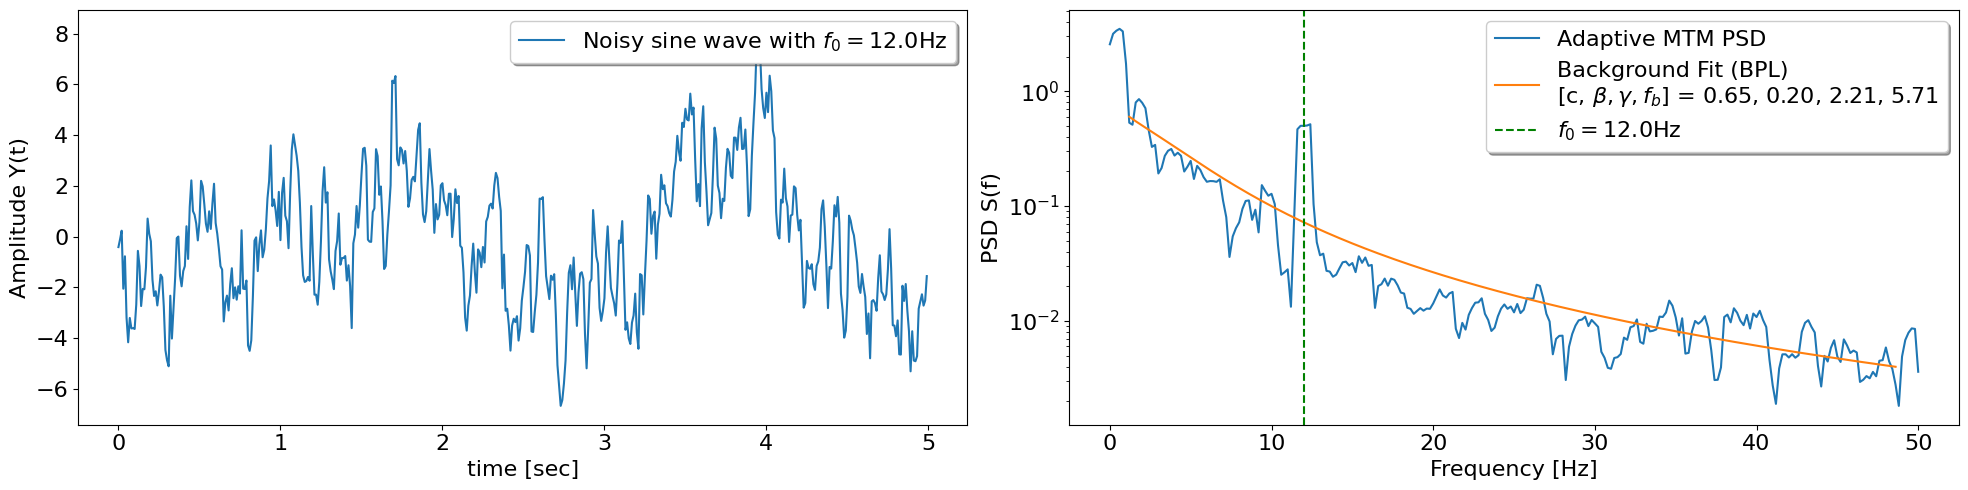

In [6]:
#-------------
def test_background_fit_():
    """Test get_pietro_spec_params and fit_spectra_background"""
    #----------Generating Time Series---------------v
    #-OG Data params-
    ds = 100 #sampling rate, equivalent to dt = 0.002s
    dt = 1/ds
    afT = np.arange(0, 5, dt) #5 second interval with 1000 dtps (N = T*ds or T = N*dt)
    N = len(afT)
    f_ray = 1/(N*dt)
    f_nyq = 1/(2*dt)
    print('Rayleigh frequency is', f_ray, 'and N = ', N)
    #-Defining various time series
    freq1 = 12#8.0
    OG_sine = fSine(1,freq1,afT) #pure sine wave with f = freq1 Hz
    np.random.seed(2) #define seed so we get consistent random values
    mu, sigma = 0, 1 # standard normal distribution (Gaussian with mu = 0 and sigma = 1)
    afWhite = np.random.normal(mu, sigma, len(afT)) #making white noise based on normal (Gaussian) distribution
    #---Define time series with [insert] noise----
    achNoise = 'red'
    if achNoise == 'red': #make time series embedded in red noise (AR(1))
        afRed = get_ar1_rednoise(len(afT), afWhite) #return AR(1) red noise
        afX = OG_sine + afRed #define sine wave embedded in red noise
    else: #make time series embedded in white noise
        afX = OG_sine + afWhite #define sine wave embedded in white noise
        
    #-----------------------------------------------
    #---------Producing aMTM Spectral Dataproducts from data series---------v
    nw_in = 3 #Ktpr = 5
    achSpect = ''
    [afFreq_mtm, afSk_mtm, afAlpha_mtm, Ftest_mtm] = get_amtm_specs(afX, afT, achSpect,nw_in) #extract Pietro aMTM PSD and dpss
    #-----------------------------------------------------------------------
    #---------Extract Background-Modelled PSD--------------v
    achFIT = 'BPL' #background fit model
    frange_in = None#[5, 20]#None #frequency range to background fit over
    [afFk_bkg, afBk, FITparams] = get_background_psdfit(afT, afFreq_mtm, afSk_mtm, afAlpha_mtm, achFIT,nw_in, frange_in) 
    
    
    
    if achFIT == 'BPL':
        achPSDfit = r'[c, $\beta, \gamma, f_b$] = %0.2f, %0.2f, %0.2f, %0.2f'%(FITparams[0], FITparams[1], FITparams[2], FITparams[3])
    elif achFIT == 'PL':
        achPSDfit = r'[c, $\beta$] = %0.2f, %0.2e'%(FITparams[0], FITparams[1])
    else: #default WHT solution
        achPSDfit = '[c] = %0.2f'%(FITparams)
    #----------------------------------------------
    #--Plotting time series, aMTM PSD, and background noise-modelled PSDS--------------------------v
    #-Using GridSpec to plot the various time series and corresponding FFTs
    fig = plt.figure(figsize = (20,5))
    gs = GridSpec(1, 2, figure=fig) # (Row x Col) plot
    ax1 = fig.add_subplot(gs[0, 0]) 
    ax2 = fig.add_subplot(gs[0, 1]) 
    fsize = 16 #fontsize of axis labels/ticks
    legsize = 18 #legend fontsize
    tsize = 12 #titlesize    
        #-Plotting Time Series
    ax1.plot(afT, afX, label = r'Noisy sine wave with $f_0 = %0.1f$Hz'%(freq1))
    ax1.legend(loc = 'upper right', shadow = True, prop={'size': legsize-2})
    ax1.set_ylabel('Amplitude Y(t)', fontsize = fsize)
    ax1.set_xlabel('time [sec]', fontsize = fsize)
        #-Plotting PSD with background fit
    ax2.semilogy(afFreq_mtm, afSk_mtm, label = 'Adaptive MTM PSD')
    ax2.semilogy(afFk_bkg, afBk, label = 'Background Fit (%s)\n%s'%(achFIT, achPSDfit))
    ax2.axvline(freq1, color = 'green', ls = '--', label = r'$f_0 = %0.1f$Hz'%(freq1))
    ax2.set_ylabel('PSD S(f)', fontsize = fsize)
    ax2.set_xlabel('Frequency [Hz]', fontsize = fsize)
    #ax2.set_xlim(0, 30)
    ax1.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax2.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
        #-Setting tick axes labelsize
    ax1.tick_params(axis='both', labelsize=fsize)
    ax2.tick_params(axis='both', labelsize=fsize) 
    plt.tight_layout()
    return;

test_background_fit_()

# 3) Simple Example which Calculates the confidence thresholds of the $\gamma$-test and F-test to determine if a PSD enhancement is a discrete periodic signal
* `get_gamtest_confs` and `get_ftest_confs`:**After first ensuring that our spectral products ($S_k,f_k,α_k,F_k$) matches the frequency-range of our background modelled PSD ($B_k$). We compute of the confidence levels (90%, 95%, 99%) of both the $\gamma$-test ($\gamma_k = S_k/B_k$) and Harmonic F-test to explicitly determine if spectral peak(s) are statistically significant (passes both dual-confidence levels)**
---
* After generating the aMTM (1) and background-modelled (2) PSD using `get_amtm_specs` and `get_background_psdfit()`, the below test cell computes the respective confidence levels of the $\gamma$-test and Ftest. After which, it uses `get_gftest_confpeaks` to determine where the Ftest and $\gamma$-test have intersecting and individual peaks above their respective confidence levels. We simply call our functions as:
* `[Fcrit90, Fcrit95, Fcrit99, afFtest_trim] = get_ftest_confs(Ktprs, afT, afFreqk, afFtestk, nw_in, Frange)`
---
* `[afGamk, Gcrit90, Gcrit95, Gcrit99, Gcrit50] = get_gamtest_confs(afT, afFreqk, afSk, afAlphak, afBk, nw_in, Frange)`   
---    
* `[Fpeaks, Gpeaks, FG_pk, FG_pkfreq] = get_gftest_confpeaks(afFreqk_bkg, afGamk, afFtest_trim, Fcrit99, Gcrit99)`
    

In [7]:
#help(get_gamtest_confs)

In [8]:
#help(get_ftest_confs)

In [9]:
#help(get_gftest_confpeaks)

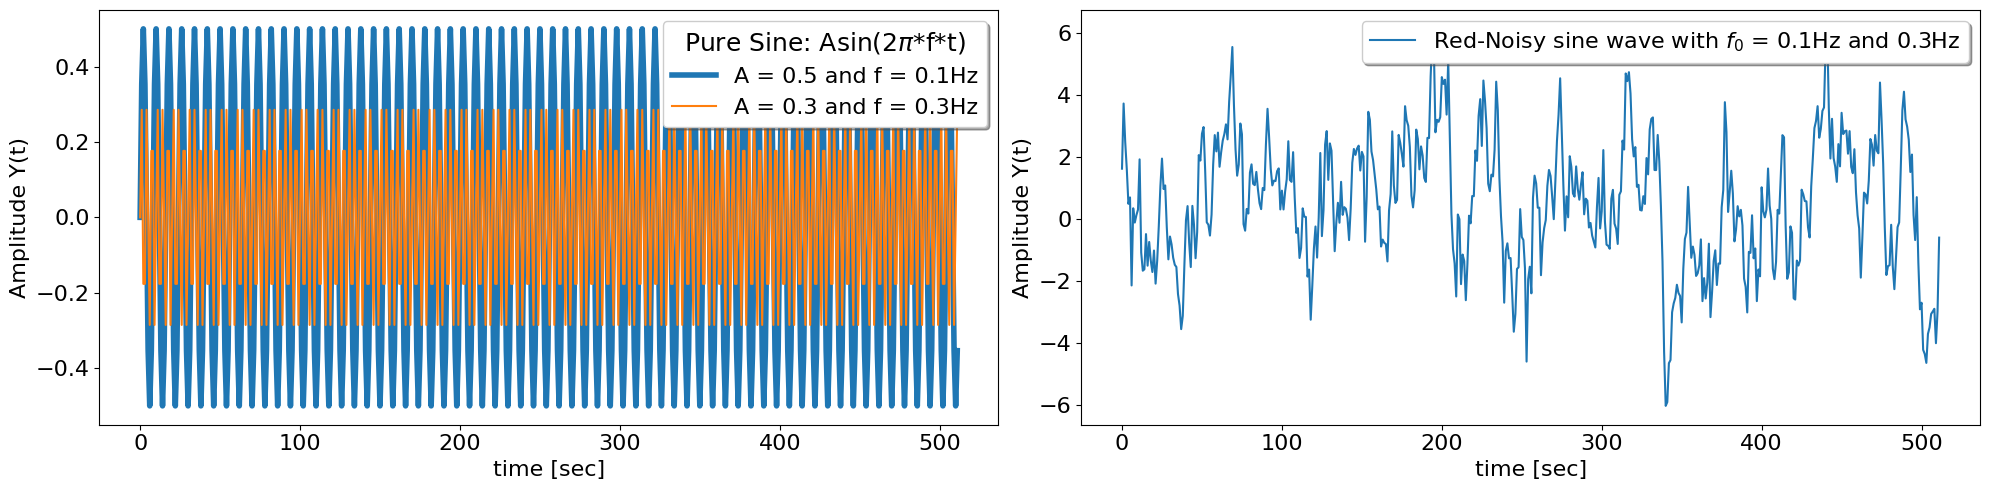

In [13]:
def example_2sine_rednoise():
    """Embed two sine waves (different freqs and amplitude in red noise)"""
    #----------Generating Time Series---------------v    
    afTime = np.arange(0,512,1) #time array from 0-511seconds, dt = 1
    freq1 = 1/8
    freq2 = 0.3
    OG_sine1 = fSine(0.5,freq1,afTime) #pure sine wave with A = 0.5 and f = 1/8 Hz (cycles/sec)
    OG_sine2 = fSine(0.3,freq2,afTime) #pure sine wave with A = 0.3 and f = 0.25 Hz (cycles/sec)
    afSine = OG_sine1 + OG_sine2
    
    np.random.seed(1) #define seed so we get consistent random values
    mu, sigma = 0, 1 # standard normal distribution (Gaussian with mu = 0 and sigma = 1)
    afWhite = np.random.normal(mu, sigma, len(afTime)) #making white noise based on normal (Gaussian) distribution
    afRed = get_ar1_rednoise(len(afTime), afWhite) #return AR(1) red noise
    afX = afSine + afRed
    
    #----------------------------------------------
    #--Plotting time series, aMTM PSD, and background noise-modelled PSDS--------------------------v
    #-Using GridSpec to plot the various time series and corresponding FFTs
    fig = plt.figure(figsize = (20,5))
    gs = GridSpec(1, 2, figure=fig) # (Row x Col) plot
    ax1 = fig.add_subplot(gs[0, 0]) 
    ax2 = fig.add_subplot(gs[0, 1]) 
    fsize = 16 #fontsize of axis labels/ticks
    legsize = 18 #legend fontsize
    tsize = 12 #titlesize    
        #-Plotting Time Series with no noise
    ax1.plot(afTime, OG_sine1, lw = 4, label = 'A = 0.5 and f = %0.1fHz'%(freq1))
    ax1.plot(afTime, OG_sine2, label = 'A = 0.3 and f = %0.1fHz'%(freq2))
    #ax1.plot(afTime, afSine, label = 'Dual Sine waves')
    ax1.legend(loc = 'upper right', shadow = True, prop={'size': legsize-2})
    ax1.set_ylabel('Amplitude Y(t)', fontsize = fsize)
    ax1.set_xlabel('time [sec]', fontsize = fsize)
        #-Plotting  Time Series with red noise
    ax2.plot(afTime, afX, label = r'Red-Noisy sine wave with $f_0$ = %0.1fHz and %0.1fHz'%(freq1, freq2))
    ax2.legend(loc = 'upper right', shadow = True, prop={'size': legsize-2})
    ax2.set_ylabel('Amplitude Y(t)', fontsize = fsize)
    ax2.set_xlabel('time [sec]', fontsize = fsize)
    ax1.legend(title = 'Pure Sine: Asin(2$\pi$*f*t)', title_fontsize = legsize,loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax2.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
        #-Setting tick axes labelsize
    ax1.tick_params(axis='both', labelsize=fsize)
    ax2.tick_params(axis='both', labelsize=fsize) 
    plt.tight_layout()    
    return;

example_2sine_rednoise()

Nyquist frequency =  0.5 , dt =  1 , T =  511 , N =  512
Creating Prieto MTSPEC class for Data(NW = 3, Ktpr = 5)
	Default Fitting Frequency Range: 0.0 to 0.5 Hz
	BPL Fitting over (default) frequency range: [0.01, 0.49] Hz
	Using SLSQP optimize method--v
	Optimized BPL Params for [c, beta, gamma, fb]:
		 [21.56170489  0.38210386  1.81496325  0.02974838]

**Finding overlapping FG-peaks within 1 bandwidth (1*NW*fray = 0.006Hz)
New NWfray-bw intersection Gpeak freqs: [0.12109375 0.125      0.12890625 0.30664062 0.3125    ]
New NWfray-bw intersection Fpeak freqs: [0.125      0.31054688]
Intersecting index locations: [ 58 153] [0.125      0.31054688]


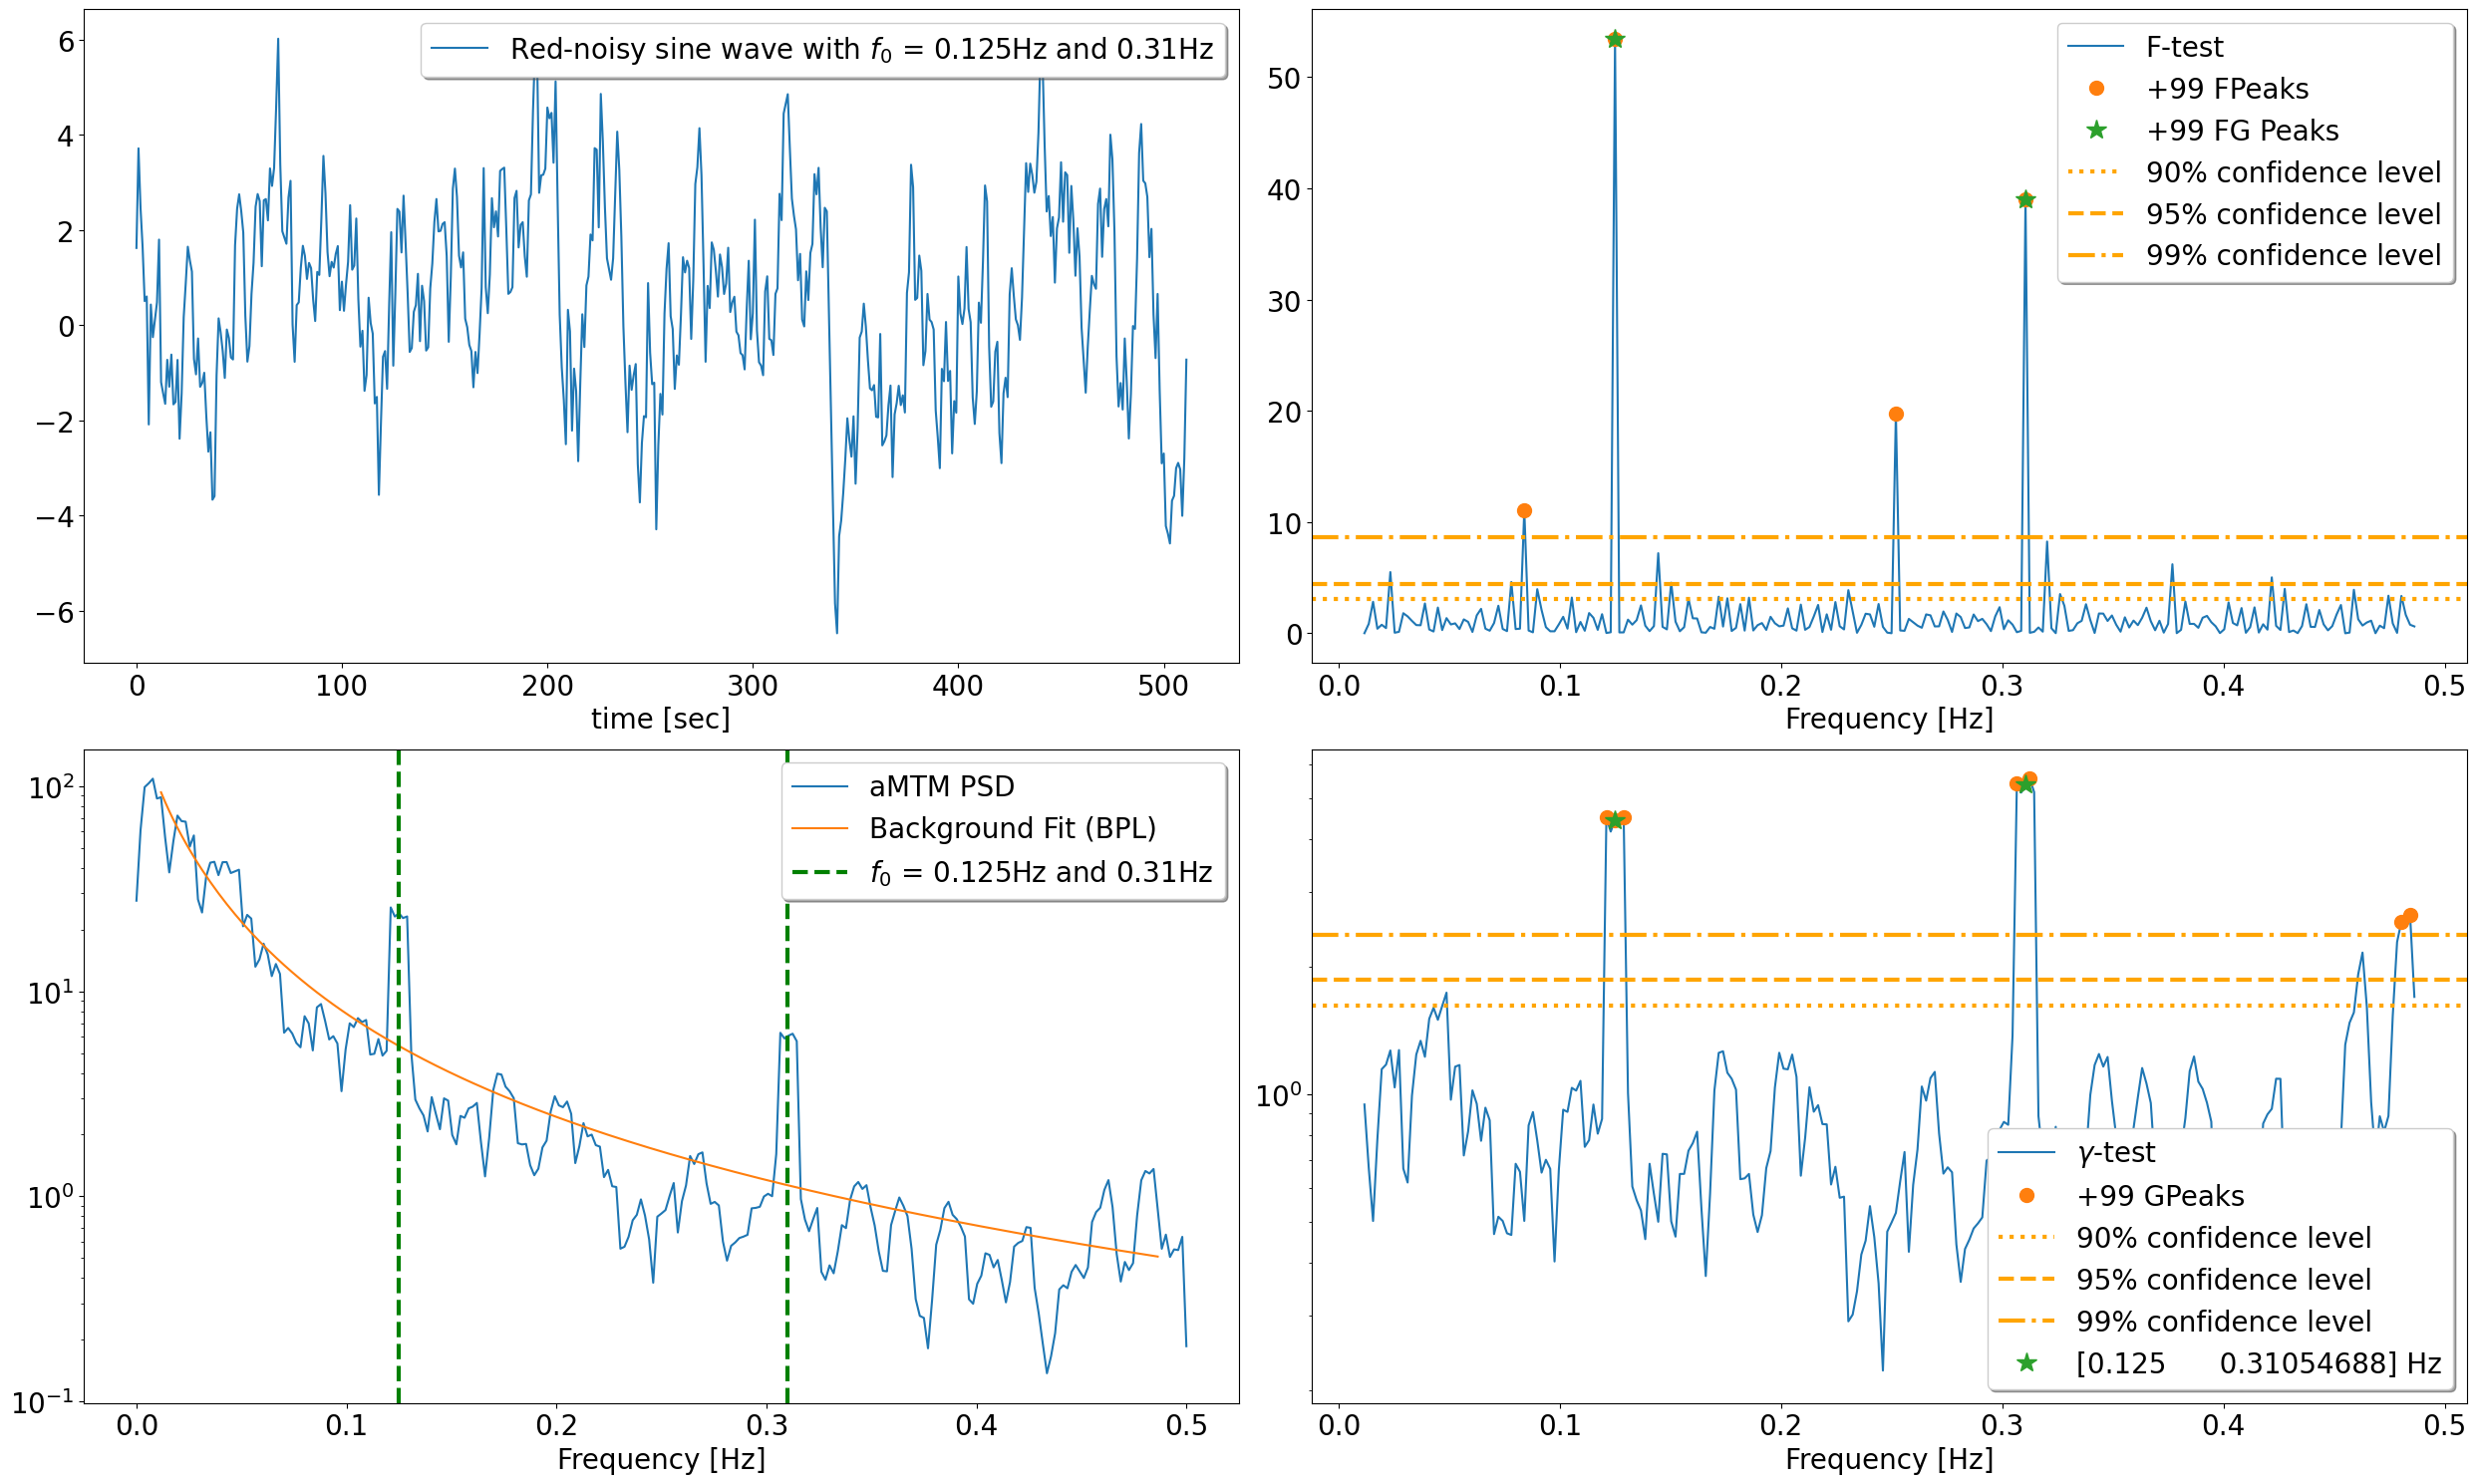

In [11]:
def test_mtm_confs():
    """Testing get_ftest_confs, get_gamtest_confs and get_gftest_conf peaks"""
    #----------Generating Time Series---------------v    
    afTime = np.arange(0,512,1) #time array from 0-511seconds, dt = 1
    freq1 = 1/8
    freq2 = 0.31
    OG_sine1 = fSine(0.5,freq1,afTime) #pure sine wave with A = 0.5 and f = 1/8 Hz (cycles/sec)
    OG_sine2 = fSine(0.3,freq2,afTime) #pure sine wave with A = 0.3 and f = 0.25 Hz (cycles/sec)

    np.random.seed(1) #define seed so we get consistent random values
    mu, sigma = 0, 1 # standard normal distribution (Gaussian with mu = 0 and sigma = 1)
    afWhite = np.random.normal(mu, sigma, len(afTime)) #making white noise based on normal (Gaussian) distribution
    afRed = get_ar1_rednoise(len(afTime), afWhite) #return AR(1) red noise
    afX = OG_sine1 + afRed + OG_sine2
    
    
    
    #-----------------------------------------------    
    #---------Produce aMTM Spectral Dataproducts and Background PSD fit from data series---------v
    achFit = 'BPL'
    nw_in = 3
    ktpr_in = None
    achSpect = ''
    [afFk, afSk, afAlphak, afFtest] = get_amtm_specs(afX, afTime, achSpect, nw_in) #NW = 3, Ktpr = 5
    [afFk_bkg, afBk, FITparams] = get_background_psdfit(afTime,afFk, afSk, afAlphak, achFit, nw_in) #Extract Spectra Background Fit
    #------------------------------------------------------------
    #---Extracting F/Gam-test confidence levels and peaks above confidenve levels---v
    [Fcrit90, Fcrit95, Fcrit99, Ftest_in] = get_ftest_confs(2*nw_in-1, afTime, afFk, afFtest, nw_in, Frange = None)
    [afGamk, Gcrit90, Gcrit95, Gcrit99, Gcrit50] = get_gamtest_confs(afTime, afFk, afSk, afAlphak, afBk, nw_in)    
    [Fpeaks, Gpeaks, Gpkfreq_intr, Fpkfreq_intr, FGpk_ind] = get_gftest_confpeaks(afFk_bkg, afGamk, Ftest_in, Fcrit99, Gcrit99, nw_in, afTime)
    
    
    
    
    
    #print('\n**New NWfray intersection Gpeak freqs:', nGpkfreq_intr) 
    #print('New NWfray intersection Fpeak freqs:', nFpkfreq_intr)
    #'''
    #print('F99peaks freqs:\n', afFk_bkg[Fpeaks])
    #print('G99peaks freqs:\n', afFk_bkg[Gpeaks])
    achLabFGpks = '%s Hz'%(Fpkfreq_intr)
    
    #''';    
    #---------------------------------------------
    #--Plotting time series, aMTM PSD with background fit, F-test, and gamma-test--------------------------v
    #-Using GridSpec to plot the various time series and corresponding FFTs
    fig = plt.figure(figsize = (25,15))
    gs = GridSpec(2, 2, figure=fig) # (Row x Col) plot
    ax1 = fig.add_subplot(gs[0, 0]) #time series
    ax2 = fig.add_subplot(gs[1, 0]) #aMTM PSD with background fit
    ax3 = fig.add_subplot(gs[0, 1]) #F-test with conf levels
    ax4 = fig.add_subplot(gs[1, 1]) #gamma-test with confidence levels
    fsize = 20 #fontsize of axis labels/ticks
    legsize = 22 #legend fontsize
    tsize = 20 #titlesize
    f_lw = 3
        #-Plotting Time Series
    ax1.plot(afTime, afX, label = r'Red-noisy sine wave with $f_0$ = %0.3fHz and %0.2fHz'%(freq1, freq2))
    ax1.legend(loc = 'upper right', shadow = True, prop={'size': legsize-2})
    #ax1.set_ylabel('Amplitude Y(t)', fontsize = fsize)
    ax1.set_xlabel('time [sec]', fontsize = fsize)
        #-Plotting PSD with background fit
    ax2.semilogy(afFk, afSk, label = 'aMTM PSD')
    ax2.semilogy(afFk_bkg, afBk, label = 'Background Fit (%s)'%(achFit))#, achPSDfit))
    ax2.axvline(freq1, color = 'green', ls = '--', lw = f_lw, label = r'$f_0$ = %0.3fHz and %0.2fHz'%(freq1, freq2))
    ax2.axvline(freq2, color = 'green', ls = '--', lw = f_lw)

    #ax2.set_ylabel('PSD S(f)', fontsize = fsize)
    ax2.set_xlabel('Frequency [Hz]', fontsize = fsize)
        #-Plotting F-test with conf levels
    ax3.plot(afFk_bkg, Ftest_in, label = 'F-test')
    ax3.plot(afFk_bkg[Fpeaks], Ftest_in[Fpeaks], 'o', ms = 10, label = '+99 FPeaks')
    ax3.plot(afFk_bkg[FGpk_ind], Ftest_in[FGpk_ind], '*', ms = 15, label = '+99 FG Peaks')
    ax3.axhline(y = Fcrit90,linestyle = 'dotted',lw = f_lw, color = 'orange', label = '90% confidence level')
    ax3.axhline(y = Fcrit95,linestyle = 'dashed',lw = f_lw, color = 'orange', label = '95% confidence level')
    ax3.axhline(y = Fcrit99,linestyle = 'dashdot',lw = f_lw, color = 'orange', label = '99% confidence level')
    ax3.set_xlabel('Frequency [Hz]', fontsize = fsize)
        #-Plotting Gamma-test (aka, amplitude- or A-test) with conf levels
    ax4.semilogy(afFk_bkg, afGamk, label = r'$\gamma$-test')
    ax4.semilogy(afFk_bkg[Gpeaks], afGamk[Gpeaks], 'o', ms = 10, label = '+99 GPeaks')
    ax4.axhline(y = Gcrit90,linestyle = 'dotted',lw = f_lw, color = 'orange', label = '90% confidence level')
    ax4.axhline(y = Gcrit95,linestyle = 'dashed',lw = f_lw, color = 'orange', label = '95% confidence level')
    ax4.axhline(y = Gcrit99,linestyle = 'dashdot',lw = f_lw, color = 'orange', label = '99% confidence level')
    #ax[2].axhline(y = Gcrit50,linestyle = 'dashdot', color = 'green', label = '50% confidence level')
    ax4.semilogy(afFk_bkg[FGpk_ind], afGamk[FGpk_ind], '*', ms = 15, label = '%s'%(achLabFGpks))
    ax4.set_xlabel('Frequency [Hz]', fontsize = fsize)
        #-Legend parameters
    ax1.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax2.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax3.legend(loc = 'upper right', shadow = True,prop={'size': legsize-2})
    ax4.legend(loc = 'lower right', shadow = True,prop={'size': legsize-2})
        #-Setting tick axes labelsize
    ax1.tick_params(axis='both', labelsize=fsize)
    ax2.tick_params(axis='both', labelsize=fsize) 
    ax3.tick_params(axis='both', labelsize=fsize) 
    ax4.tick_params(axis='both', labelsize=fsize) 
    plt.tight_layout()
    #fig.savefig('testdirect.png', facecolor = 'w')
    #plt.savefig('jgrTech_dualconftest_BPLfit_redAR1noise_example.png', bbox_inches='tight', facecolor = 'w')
    return;
test_mtm_confs()